# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, UpSampling2D, SpatialDropout2D, BatchNormalization, ReLU

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convolutional Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder convolucional e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [20]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/CelebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [44]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='training',
    batch_size=8,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='validation',
    batch_size=8,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [45]:
print('- ' * 10)
print(f'{int(len(train_ds) * 8)} - {int(len(train_ds) * 8) / 202599:.2%}')
print(f'{int(len(test_ds) * 8)} - {int(len(test_ds) * 8) / 202599:.2%}')
print(f'{int(len(val_ds) * 8)} - {int(len(val_ds) * 8) / 202599:.2%}')

- - - - - - - - - - 
145880 - 72.00%
36464 - 18.00%
20264 - 10.00%


## Normalização dos valores

In [46]:
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [47]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(8, 176, 216, 3)
(8, 176, 216, 3)
(8, 176, 216, 3)


In [48]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

## Definição do Conv Autoencoder

In [49]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [50]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=.5,
)

In [51]:
conv_autoencoder = Sequential([
    # Entrada
    InputLayer(shape=(176, 216, 3)),


    # --- Encoder ---
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),
    SpatialDropout2D(.2),

    MaxPool2D(),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),
    SpatialDropout2D(.2),

    MaxPool2D(),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),
    SpatialDropout2D(.2),

    MaxPool2D(),


    # --- Decoder ---
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),

    UpSampling2D(),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),

    UpSampling2D(),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    ReLU(),

    UpSampling2D(),


    # Saída
    Conv2D(3, (3,3), padding='same', activation='sigmoid')
])

In [52]:
conv_autoencoder.compile(optimizer='adam', loss='mse')

In [53]:
conv_autoencoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 176, 216, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 176, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 176, 216, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 176, 216, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 88, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 88, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 88, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 88, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 88, 108, 64)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 44, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 44, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 44, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 44, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 44, 54, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 22, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 22, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 22, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 44, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 44, 54, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 44, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

## Treinamento do autoencoder

In [54]:
history = conv_autoencoder.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[reduce_lr])

Epoch 1/5
18235/18235 ━━━━━━━━━━━━━━━━━━━━ 290s 14ms/step - loss: 0.0058 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 2/5
18235/18235 ━━━━━━━━━━━━━━━━━━━━ 258s 13ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/5
18235/18235 ━━━━━━━━━━━━━━━━━━━━ 260s 13ms/step - loss: 0.0023 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/5
18235/18235 ━━━━━━━━━━━━━━━━━━━━ 264s 13ms/step - loss: 0.0020 - val_loss: 0.0020 - learning_rate: 5.0000e-04
Epoch 5/5
18235/18235 ━━━━━━━━━━━━━━━━━━━━ 263s 13ms/step - loss: 0.0019 - val_loss: 0.0020 - learning_rate: 2.5000e-04


## Salvamento e carregamento do AE

In [55]:
conv_autoencoder.save('conv_autoencoder.keras')

In [150]:
conv_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/convolutional_autoencoder/conv_autoencoder.keras')

## Definição do encoder

In [151]:
encoder = Sequential(conv_autoencoder.layers[:15])

## Gráficos e visualização

In [152]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (176, 216)) # (10, 176, 216, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, 176, 216, 3)).numpy() # (5, 2, 7452)

In [153]:
fixed_samples.shape

(5, 2, 176, 216, 3)

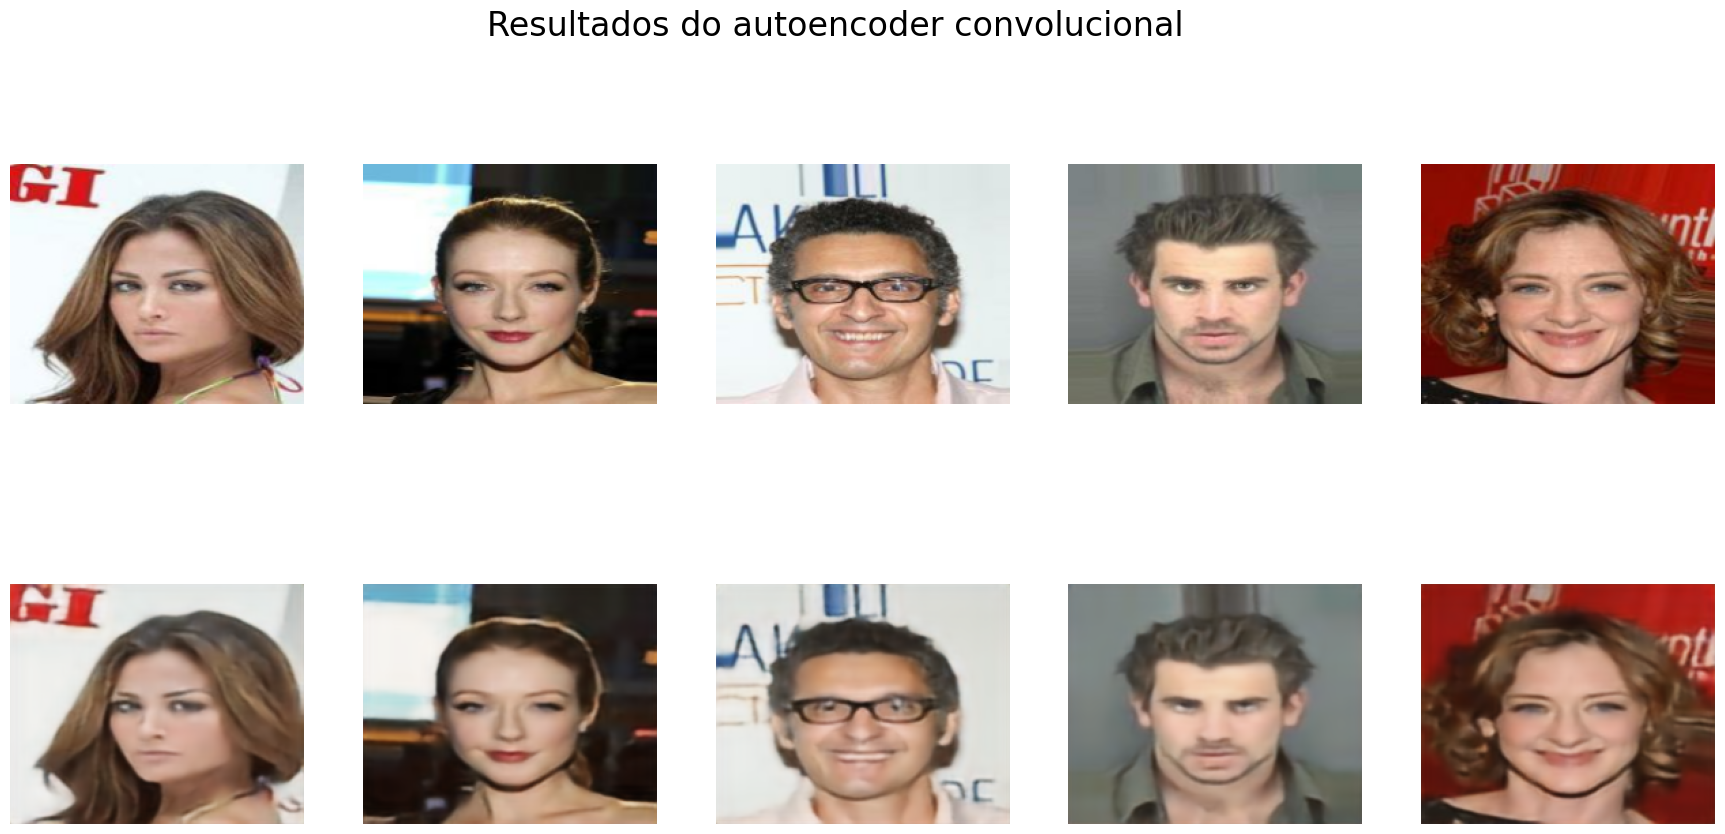

In [154]:
samples = fixed_samples

plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  decoded = conv_autoencoder.predict(im, verbose=False)

  plt.suptitle('Resultados do autoencoder convolucional', fontsize=24)

  plt.subplot(2, 5, i+1)
  plt.imshow(tf.reshape(im, (176, 216, 3)))
  plt.axis('off')

  plt.subplot(2, 5, i+6)
  plt.imshow(tf.reshape(decoded, (176, 216, 3)).numpy().astype('float32'))
  plt.axis('off')

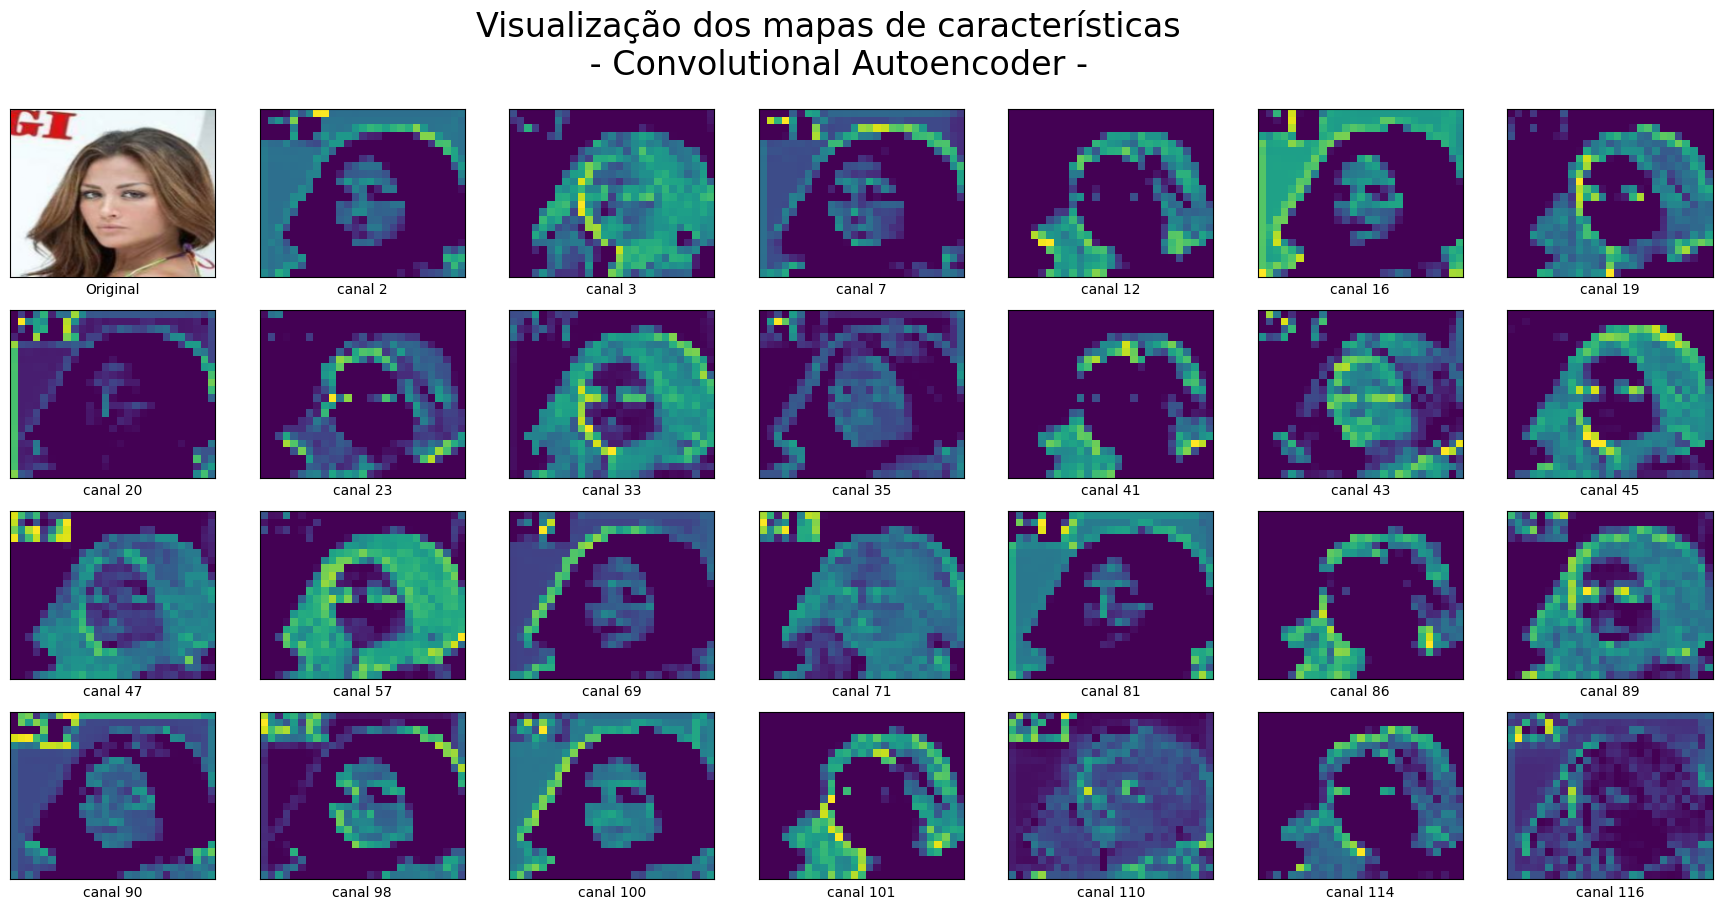

In [155]:
sample = fixed_samples[0]

original = tf.reshape(sample[0], (176, 216, 3))

n = 27
latent = encoder.predict(sample, verbose=False)[0] # Mapa de características
canais = [2,  3,   7,   12,  16,  19, 20,
          23, 33,  35,  41,  43,  45, 47,
          57, 69,  71,  81,  86,  89, 90,
          98, 100, 101, 110, 114, 116
         ]

plt.figure(figsize=(22, 10))

# Imagem original
plt.suptitle('Visualização dos mapas de características \n - Convolutional Autoencoder -', fontsize=24)
plt.subplot(4, 7, 1)
plt.imshow(original)
plt.xlabel(f'Original')
plt.xticks(())
plt.yticks(())

# Canais
for i, c in enumerate(canais):
  plt.subplot(4, 7, i+2)
  plt.imshow(latent[:, :, c].reshape(22, 27), cmap='viridis')
  plt.xlabel(f'canal {c}')
  plt.xticks(())
  plt.yticks(())

In [156]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

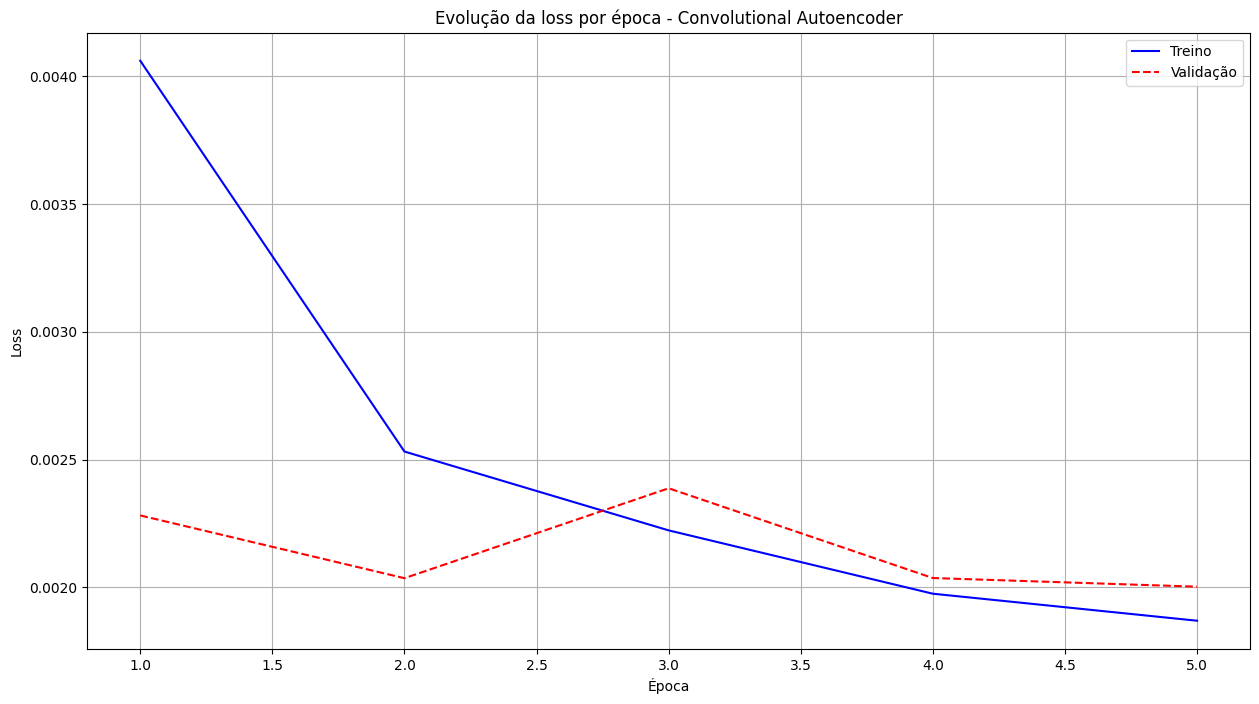

In [157]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, 'b-', label='Treino')
plt.plot(epochs, val_loss, 'r--', label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - Convolutional Autoencoder')
plt.legend()
plt.grid(True)
plt.show();